<a href="https://colab.research.google.com/github/iamlekh/NLP/blob/master/C1_W2_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np                         
import matplotlib.pyplot as plt            
from sklearn.decomposition import PCA      
import pandas as pd                        
import math                                
import random

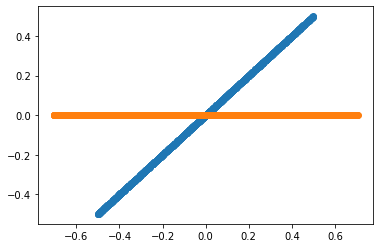

In [2]:
n = 1  
x = np.random.uniform(1,2,1000) 
y = x.copy() * n 


x = x - np.mean(x) 
y = y - np.mean(y) 

data = pd.DataFrame({'x': x, 'y': y}) 
plt.scatter(data.x, data.y) 

pca = PCA(n_components=2) 

pcaTr = pca.fit(data)

rotatedData = pcaTr.transform(data) 

dataPCA = pd.DataFrame(data = rotatedData, columns = ['PC1', 'PC2']) 


plt.scatter(dataPCA.PC1, dataPCA.PC2)
plt.show()

In [3]:
print('Eigenvectors or principal component: First row must be in the direction of [1, n]')
print(pcaTr.components_)

print()
print('Eigenvalues or explained variance')
print(pcaTr.explained_variance_)

Eigenvectors or principal component: First row must be in the direction of [1, n]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

Eigenvalues or explained variance
[1.57514184e-01 1.37530274e-32]


angle:  45.0
rotationMatrix
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


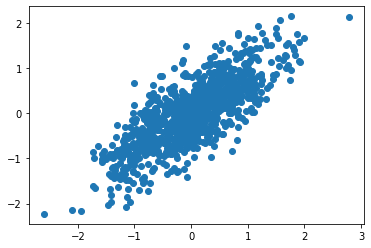

In [6]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

random.seed(100)

std1 = 1     
std2 = 0.333 

x = np.random.normal(0, std1, 1000) 
y = np.random.normal(0, std2, 1000)  



x = x - np.mean(x)  
y = y - np.mean(y) 


n = 1 
angle = np.arctan(1 / n) 
print('angle: ',  angle * 180 / math.pi)


rotationMatrix = np.array([[np.cos(angle), np.sin(angle)],
                 [-np.sin(angle), np.cos(angle)]])


print('rotationMatrix')
print(rotationMatrix)

xy = np.concatenate(([x] , [y]), axis=0).T 


data = np.dot(xy, rotationMatrix) 

plt.scatter(data[:,0], data[:,1])
plt.show()

Eigenvectors or principal component: First row must be in the direction of [1, n]
[[ 0.71459375  0.69953969]
 [-0.69953969  0.71459375]]

Eigenvalues or explained variance
[0.93724297 0.11672143]


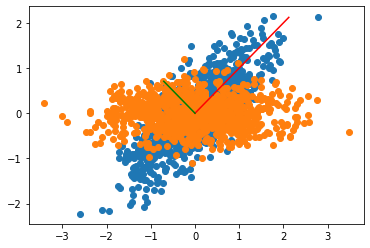

In [7]:
plt.scatter(data[:,0], data[:,1]) 

pca = PCA(n_components=2) 

pcaTr = pca.fit(data)

dataPCA = pcaTr.transform(data)

print('Eigenvectors or principal component: First row must be in the direction of [1, n]')
print(pcaTr.components_)

print()
print('Eigenvalues or explained variance')
print(pcaTr.explained_variance_)

plt.scatter(dataPCA[:,0], dataPCA[:,1])


plt.plot([0, rotationMatrix[0][0] * std1 * 3], [0, rotationMatrix[0][1] * std1 * 3], 'k-', color='red')

plt.plot([0, rotationMatrix[1][0] * std2 * 3], [0, rotationMatrix[1][1] * std2 * 3], 'k-', color='green')

plt.show()

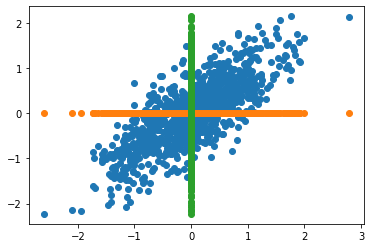

In [8]:

nPoints = len(data)

plt.scatter(data[:,0], data[:,1])

plt.scatter(data[:,0], np.zeros(nPoints))

plt.scatter(np.zeros(nPoints), data[:,1])

plt.show()